# InstrumentedPCA - Calls
- 20 Factors considered
- Features are aligned with all information being available at time t
- Unrestricted model: intercept is included
- Includes minor preprocessing, datasets saving and statistical tests


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import chi2
from ipca import InstrumentedPCA

In [24]:
calls = pd.read_csv('SPX_Processed_IPCA_calls_Trimmed.csv')
calls.drop(['put_payoff'], axis=1, inplace=True)
calls.dropna(inplace=True)
calls.rename(columns={'Unnamed: 0': 'temp_ID'}, inplace=True)
calls.drop(['option_type', 'best_ask', 'best_bid', 'best_bid_size', 'best_ask_size', 'expiration'], axis=1, inplace=True)
calls.columns

Index(['temp_ID', 'date', 'strike_price', 'spot_price', 'forward_price', 'vix',
       'div_yield', 'risk_free', 'time_to_maturity_OPT', 'moneyness',
       'option_price', 'bidask_spread', 'effective_spread', 'vwap', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'rho', 'vanna', 'charm', 'vomma', 'zomma', 'color', 'dvega_dtime',
       'return', 'his_volatility', 'realised_skewness', 'realised_kurtosis',
       'model_free_iv', 'model_free_skew', 'model_free_kurt', 'rv_iv',
       'rv_mfvol', 'rskew_mfskew', 'rkurt_mfkurt', 'call_payoff'],
      dtype='object')

In [25]:
# Monthly panels
calls['date'] = pd.to_datetime(calls['date'])
calls['month'] = calls['date'].dt.to_period('M').dt.to_timestamp().astype('int64') // 10**9

# Unique identifier based on strike and maturity to respect parity conditions
calls['unique_id'] = (calls['strike_price'].astype(str) + '_' + 
                      calls['time_to_maturity_OPT'].astype(str))

# Converting to a numeric ID
unique_ids = np.unique(calls['unique_id'])
ID_map = dict(zip(unique_ids, np.arange(1, len(unique_ids) + 1)))
calls['unique_id'] = calls['unique_id'].apply(lambda x: ID_map[x])

# MultiIndex with ID and monthly panel
calls.set_index(['unique_id', 'month'], inplace=True)

# Splitting into testing and training
max_year = calls['date'].max().year
train_data = calls[calls['date'].dt.year < (max_year - 2)]
test_data = calls[calls['date'].dt.year >= (max_year - 2)]

# Training data
X_train = train_data.drop(['call_payoff', 'date', 'temp_ID'], axis=1).select_dtypes(include=[np.number])
y_train = train_data['call_payoff']

# Testing data (stable economic conditions)
X_test = test_data.drop(['call_payoff', 'date', 'temp_ID'], axis=1).select_dtypes(include=[np.number])
y_test = test_data['call_payoff']

# Normalisation
means = X_train.mean()
stds = X_train.std()
X_train_scaled = (X_train - means) / stds
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = (X_test - means) / stds
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Panel indices
train_indices = np.array([X_train.index.get_level_values(0), X_train.index.get_level_values(1)]).T
test_indices = np.array([X_test.index.get_level_values(0), X_test.index.get_level_values(1)]).T

# Fitting IPCA with intercept (unrestricted model)
ipca = InstrumentedPCA(n_factors=20, intercept=True)
ipca.fit(X=X_train, y=y_train, indices=train_indices)
Gamma, Factors = ipca.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 71658 , L: 37 , T: 96


[========================================================================] 100%


Step 1 - Aggregate Update: 27.013719483572537
Step 2 - Aggregate Update: 4.990967278370851
Step 3 - Aggregate Update: 11.265390972046957
Step 4 - Aggregate Update: 2.9598536449020982
Step 5 - Aggregate Update: 4.980779405909072
Step 6 - Aggregate Update: 4.59233796882494
Step 7 - Aggregate Update: 2.7659181647786104
Step 8 - Aggregate Update: 8.137627470941375
Step 9 - Aggregate Update: 3.9544069012032566
Step 10 - Aggregate Update: 2.6507021512803695
Step 11 - Aggregate Update: 2.77919516809505
Step 12 - Aggregate Update: 2.5104220279023837
Step 13 - Aggregate Update: 3.4278014138496826
Step 14 - Aggregate Update: 1.87771629261173
Step 15 - Aggregate Update: 1.503958678744672
Step 16 - Aggregate Update: 1.40679446203522
Step 17 - Aggregate Update: 1.4055092686965145
Step 18 - Aggregate Update: 1.5851165831552327
Step 19 - Aggregate Update: 2.736104747283707
Step 20 - Aggregate Update: 1.7967625223890442
Step 21 - Aggregate Update: 1.7456493002181364
Step 22 - Aggregate Update: 1.22511

## Evaluation Metrics

In [26]:
# In-sample R²
r2_train = ipca.score(X=X_train, y=y_train, indices=train_indices)

# Out of sample predictions
y_test_pred = ipca.predictOOS(X=X_test, y = y_test, mean_factor=True)
# R² Pred
r2_pred = r2_score(y_test, y_test_pred)

print(f"R² (train): {r2_train}")
print(f"R² Pred (test): {r2_pred}")

R² (train): 0.9923019689597086
R² Pred (test): 0.9410608693038506


In [27]:
# Residuals for the test set
residuals_test = y_test - y_test_pred
y_train_pred = ipca.predictOOS(X=X_train, y = y_train, mean_factor=True)

# Residuals for the training set
residuals_train = y_train - y_train_pred

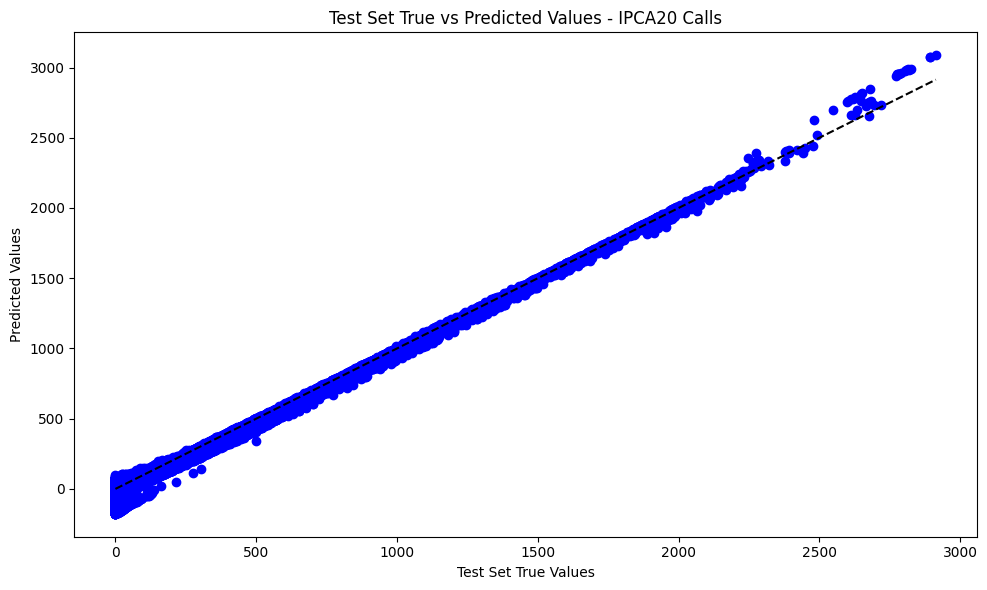

In [28]:
# y_test vs y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.xlabel('Test Set True Values')
plt.ylabel('Predicted Values')
plt.title('Test Set True vs Predicted Values - IPCA20 Calls')
plt.tight_layout()
plt.show()

### Wald Test for Coefficients Significance

In [9]:
Gamma = Gamma.values  # numpy array

# Covariance matrix of the factor loadings across the characteristics
Gamma_cov = np.cov(Gamma.T)

# Wald Test Function
def wald_test_matrix(Gamma, Gamma_cov):
    results = []
    num_loadings = Gamma.shape[0]  # 37 characteristics
    num_factors = Gamma.shape[1]  # 21 factors (20 + intercept)

    for i in range(num_loadings):
        Gamma_i = Gamma[i, :]
        wald_stat = np.dot(np.dot(Gamma_i.T, np.linalg.inv(Gamma_cov)), Gamma_i)
        df = num_factors
        p_value = 1 - chi2.cdf(wald_stat, df)
        results.append((wald_stat, p_value, "Significant" if p_value < 0.05 else "Not Significant"))

    return results

# Running the Wald test
wald_results = wald_test_matrix(Gamma, Gamma_cov)
for i, (wald_stat, p_value, significance) in enumerate(wald_results):
    print(f"Characteristic {i+1}: Wald Statistic: {wald_stat:.4f}, P-value: {p_value:.4f}, Result: {significance}")


Characteristic 1: Wald Statistic: 38.1151, P-value: 0.0125, Result: Significant
Characteristic 2: Wald Statistic: 38.8872, P-value: 0.0101, Result: Significant
Characteristic 3: Wald Statistic: 0.8358, P-value: 1.0000, Result: Not Significant
Characteristic 4: Wald Statistic: 38.7873, P-value: 0.0104, Result: Significant
Characteristic 5: Wald Statistic: 5.3679, P-value: 0.9998, Result: Not Significant
Characteristic 6: Wald Statistic: 0.2384, P-value: 1.0000, Result: Not Significant
Characteristic 7: Wald Statistic: 35.9900, P-value: 0.0219, Result: Significant
Characteristic 8: Wald Statistic: 39.2910, P-value: 0.0091, Result: Significant
Characteristic 9: Wald Statistic: 38.2008, P-value: 0.0122, Result: Significant
Characteristic 10: Wald Statistic: 30.6922, P-value: 0.0789, Result: Not Significant
Characteristic 11: Wald Statistic: 7.1665, P-value: 0.9978, Result: Not Significant
Characteristic 12: Wald Statistic: 38.2039, P-value: 0.0122, Result: Significant
Characteristic 13: Wa

### Confidence Intervals for Coefficients Significance

In [10]:
# Variance of residuals
residual_variance = np.var(residuals_train, ddof=1)  # sample variance

# Matrix to store the standard errors
std_errors_gamma = np.zeros(Gamma.shape)
for i in range(Gamma.shape[0]):  # For each characteristic (row in Gamma)
    for j in range(Gamma.shape[1]):  # For each factor (column in Gamma)
        std_errors_gamma[i, j] = np.sqrt(residual_variance / np.sum(X_train.iloc[:, j] ** 2))

# Confidence level alpha 5%
z_value = 1.96

# Confidence intervals for each loading
lower_bounds_gamma = Gamma - z_value * std_errors_gamma
upper_bounds_gamma = Gamma + z_value * std_errors_gamma

# Checking significance based on whether the CI includes zero
significant_loadings = (lower_bounds_gamma > 0) | (upper_bounds_gamma < 0)

# Arrays
significant_loadings = significant_loadings.values if isinstance(significant_loadings, pd.DataFrame) else significant_loadings
lower_bounds_gamma = lower_bounds_gamma.values if isinstance(lower_bounds_gamma, pd.DataFrame) else lower_bounds_gamma
upper_bounds_gamma = upper_bounds_gamma.values if isinstance(upper_bounds_gamma, pd.DataFrame) else upper_bounds_gamma

# Print check
for i in range(Gamma.shape[0]):  # For each characteristic
    for j in range(Gamma.shape[1]):  # For each factor
        is_significant = "Significant" if significant_loadings[i, j] else "Not Significant"
        print(f"Characteristic {i+1}, Factor {j+1}: CI = [{lower_bounds_gamma[i, j]:.4f}, {upper_bounds_gamma[i, j]:.4f}], {is_significant}")

Characteristic 1, Factor 1: CI = [-0.0261, 0.0267], Not Significant
Characteristic 1, Factor 2: CI = [-0.0261, 0.0267], Not Significant
Characteristic 1, Factor 3: CI = [-0.0253, 0.0274], Not Significant
Characteristic 1, Factor 4: CI = [-0.0254, 0.0274], Not Significant
Characteristic 1, Factor 5: CI = [-0.0254, 0.0274], Not Significant
Characteristic 1, Factor 6: CI = [0.0580, 0.1108], Significant
Characteristic 1, Factor 7: CI = [-0.0315, 0.0212], Not Significant
Characteristic 1, Factor 8: CI = [-0.0174, 0.0354], Not Significant
Characteristic 1, Factor 9: CI = [-0.5892, -0.5365], Significant
Characteristic 1, Factor 10: CI = [0.6448, 0.6976], Significant
Characteristic 1, Factor 11: CI = [-0.3343, -0.2816], Significant
Characteristic 1, Factor 12: CI = [-0.1492, -0.0964], Significant
Characteristic 1, Factor 13: CI = [-0.1062, -0.0534], Significant
Characteristic 1, Factor 14: CI = [-0.2378, -0.1850], Significant
Characteristic 1, Factor 15: CI = [-0.1151, -0.0624], Significant
Ch

### Scree Plot & Gamma-Factors Loadings

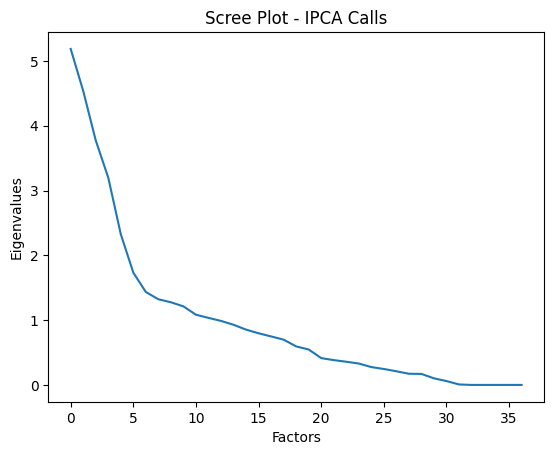

In [29]:
correlation_matrix = np.corrcoef(X_train.T)  # correlation between characteristics
eigenvalues, _ = np.linalg.eig(correlation_matrix)
sorted_eigenvalues = np.sort(eigenvalues)[::-1]

# Scree plot
plt.plot(sorted_eigenvalues)
plt.title("Scree Plot - IPCA Calls")
plt.xlabel("Factors")
plt.ylabel("Eigenvalues")
plt.show()

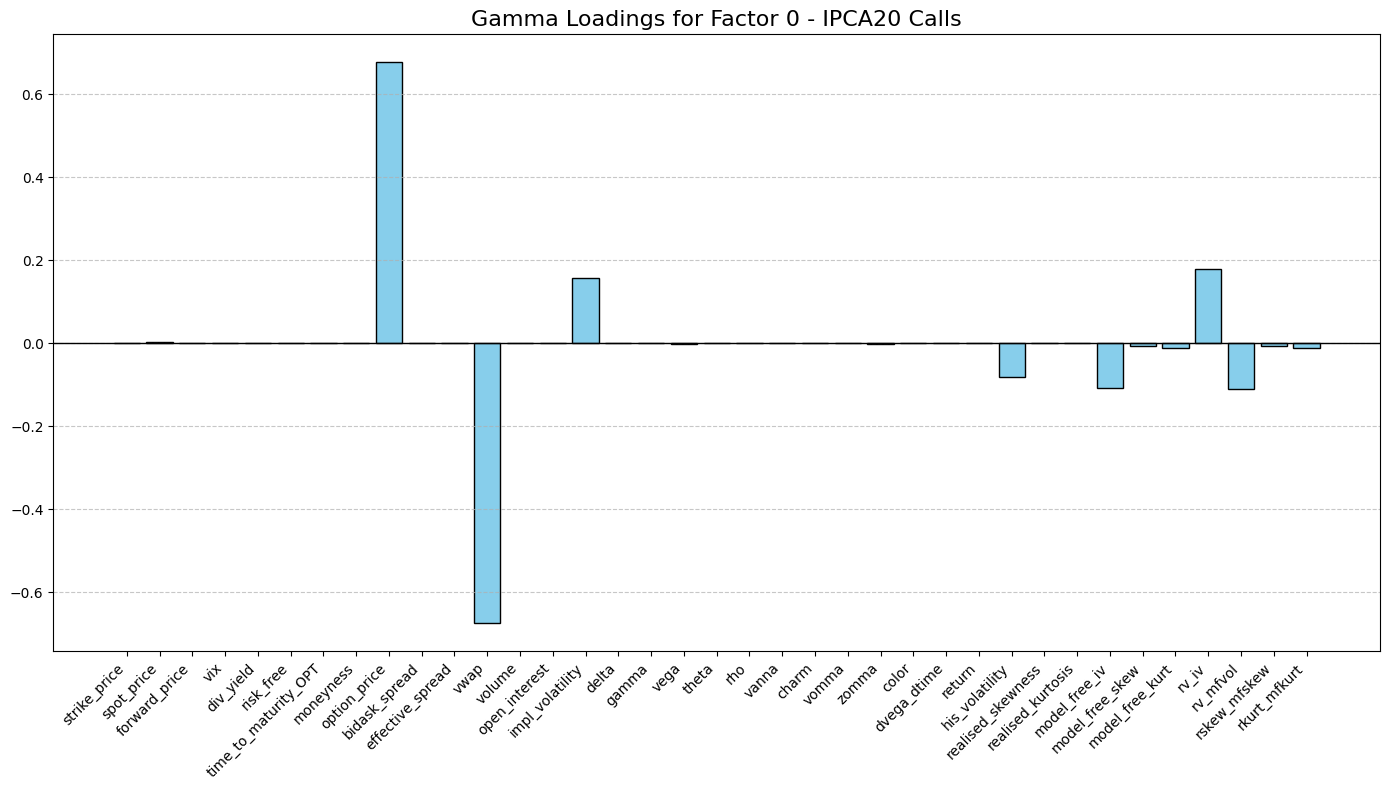

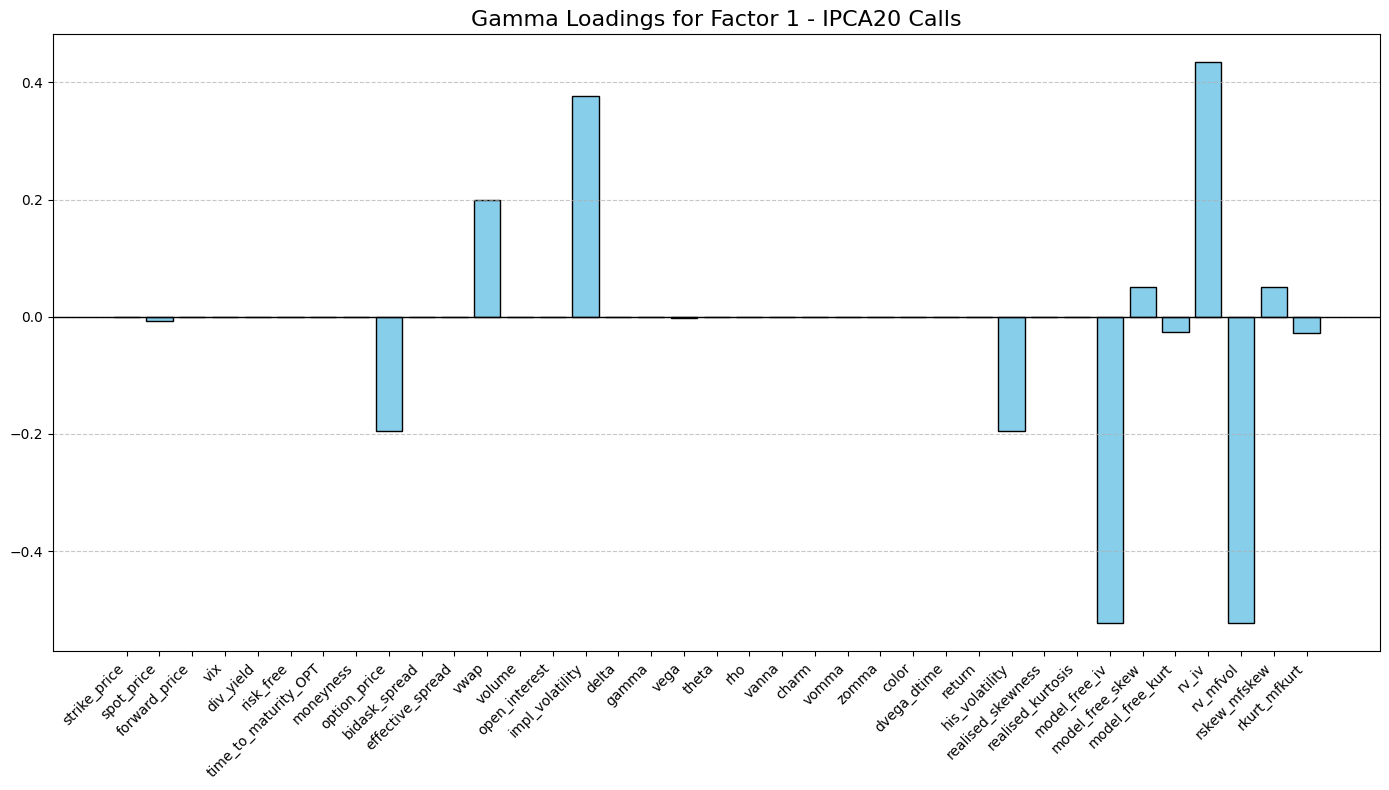

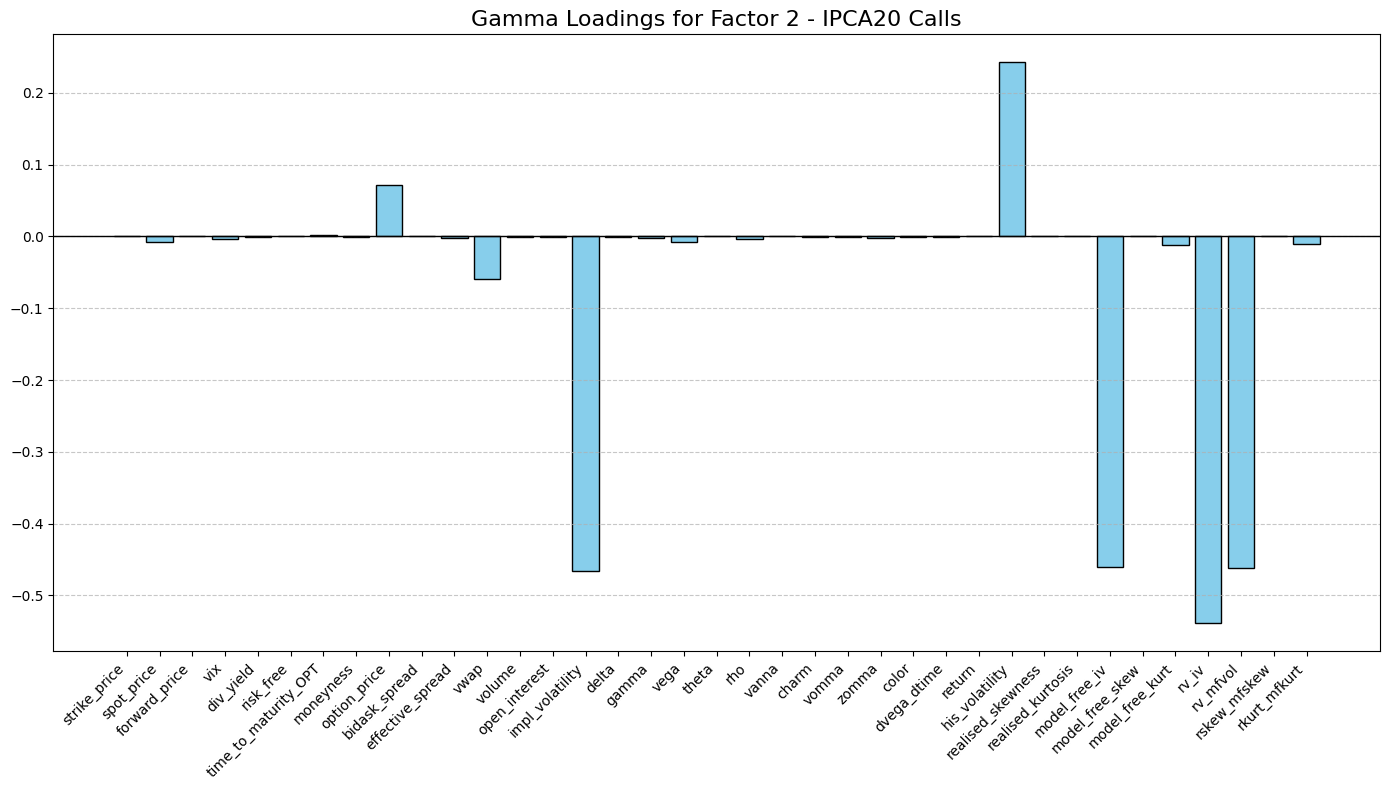

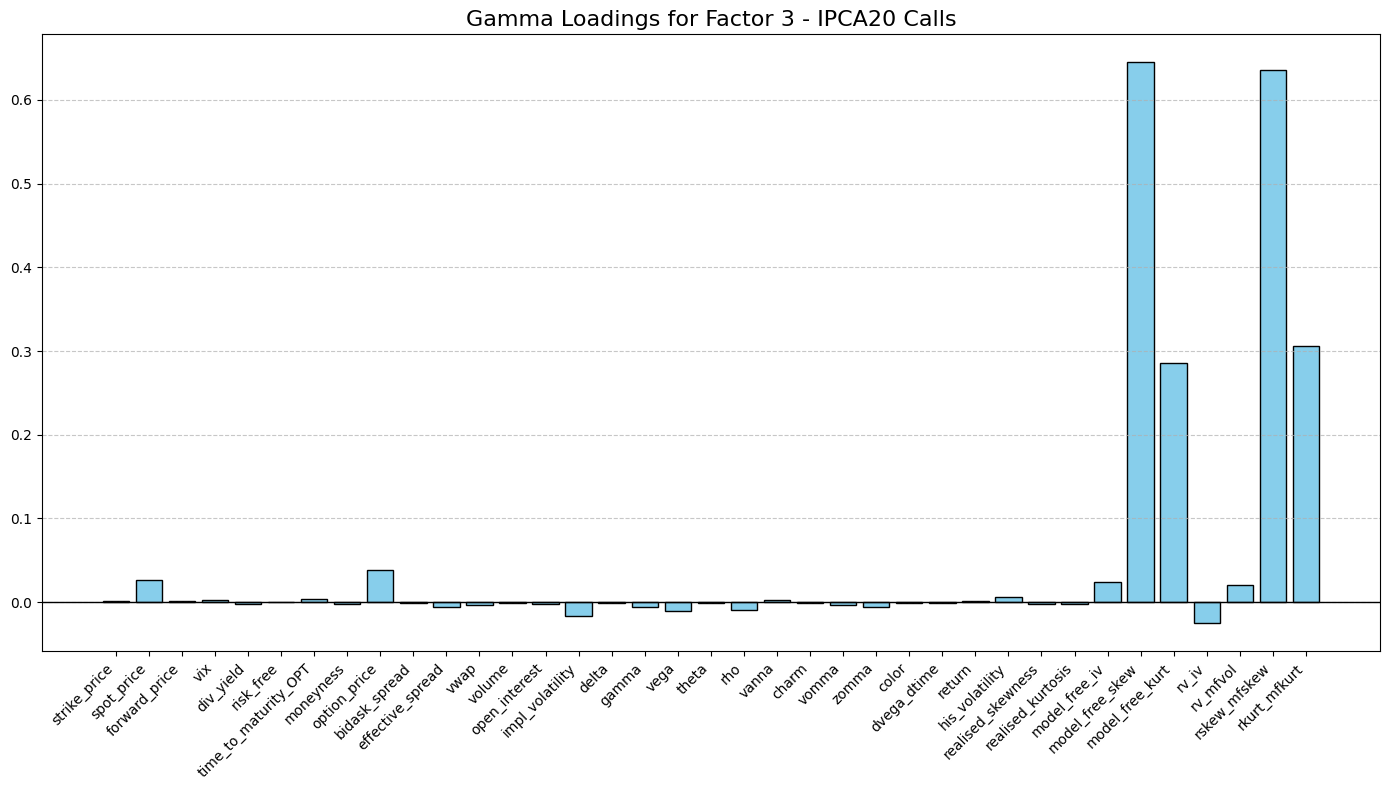

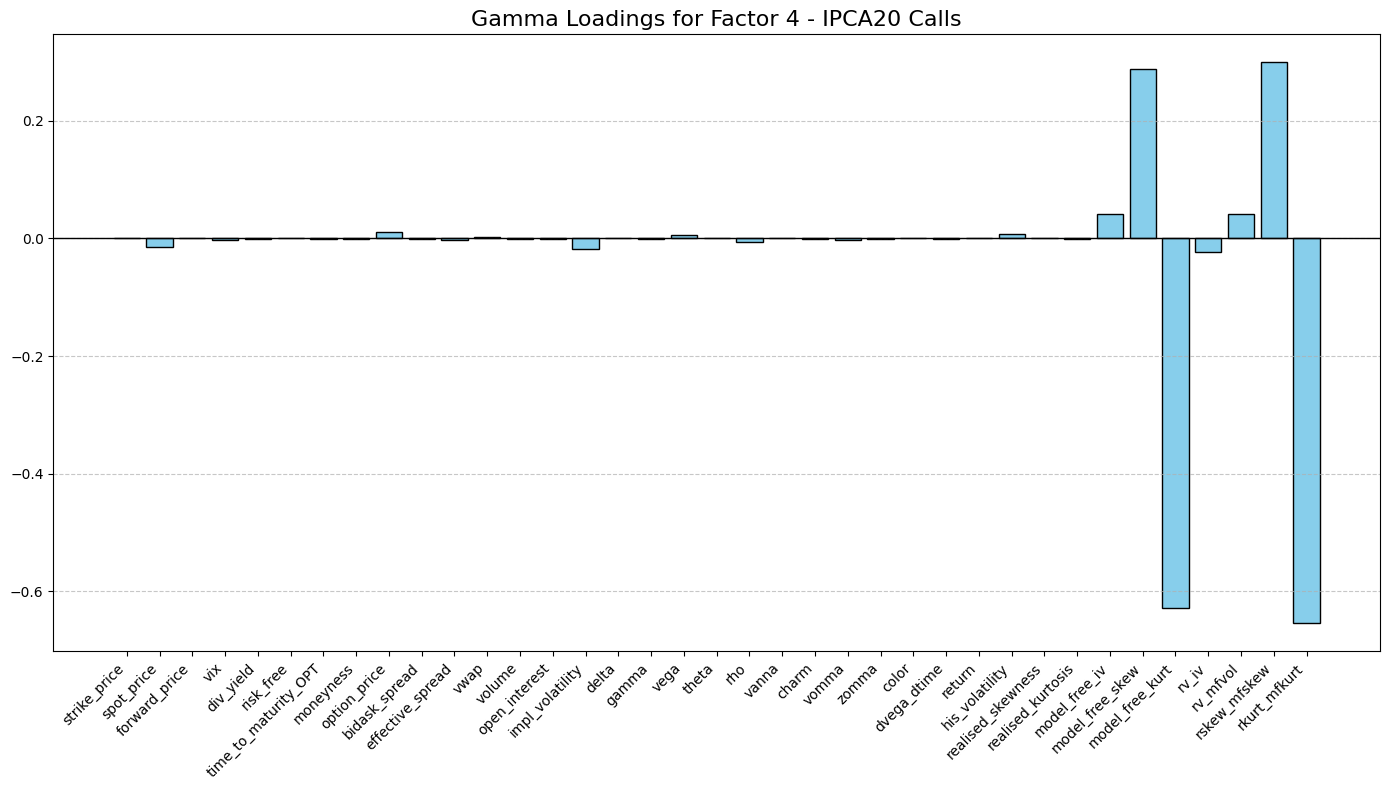

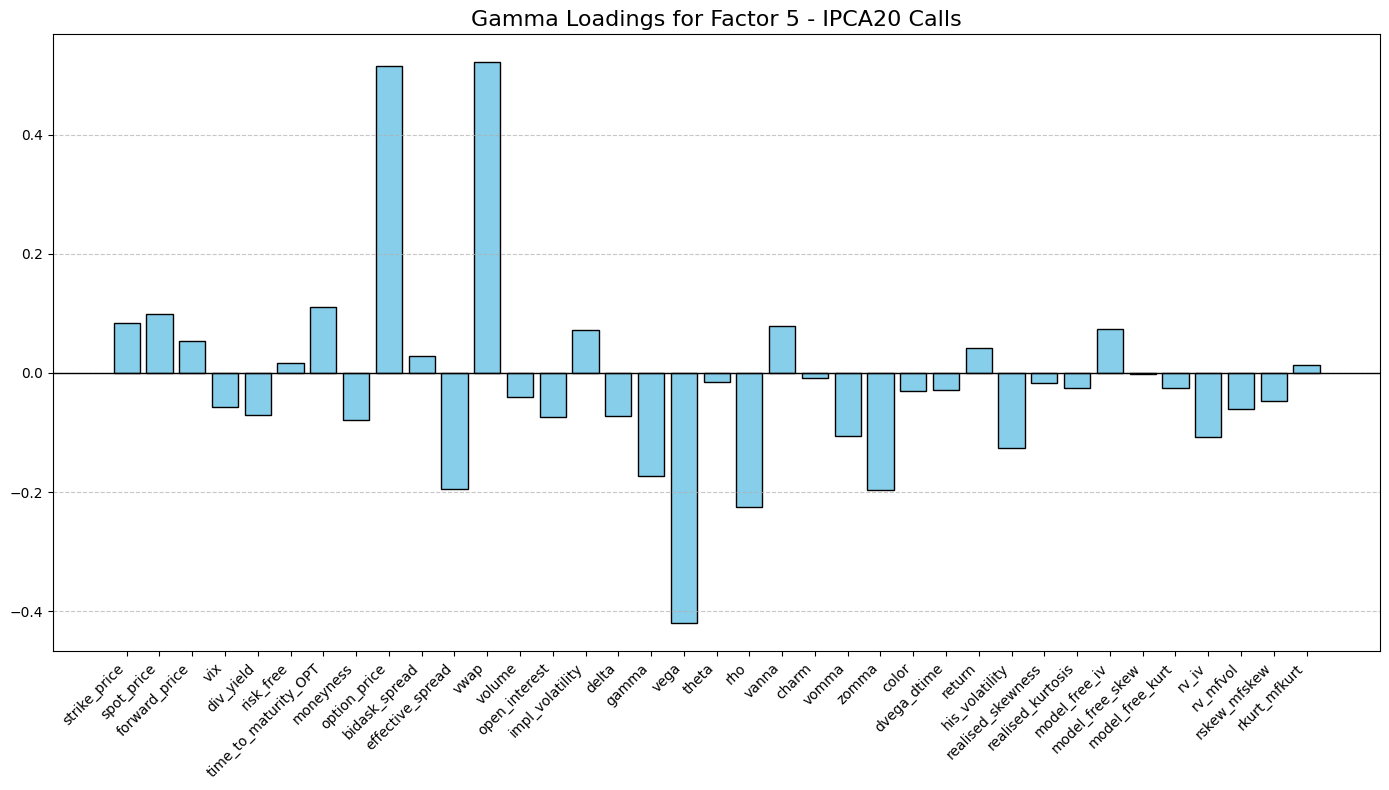

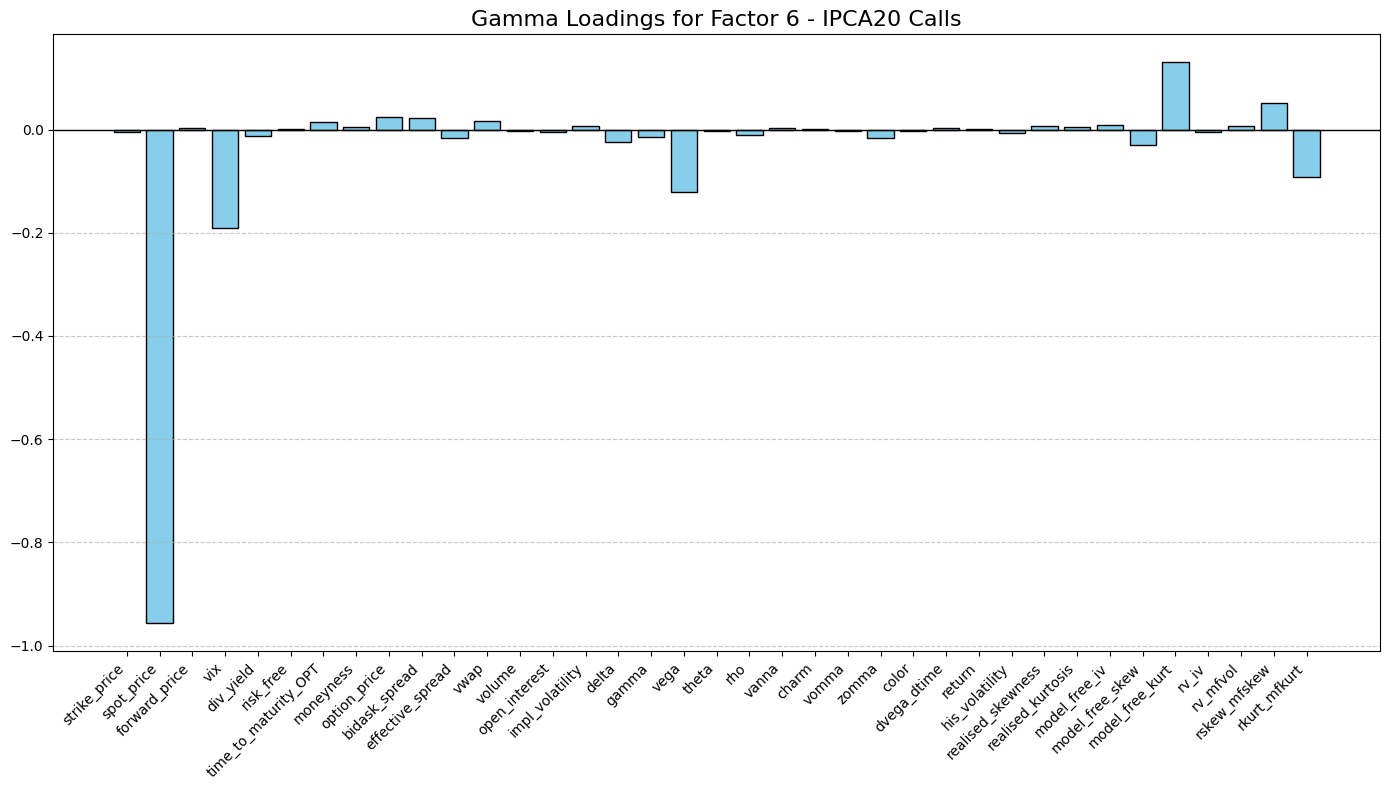

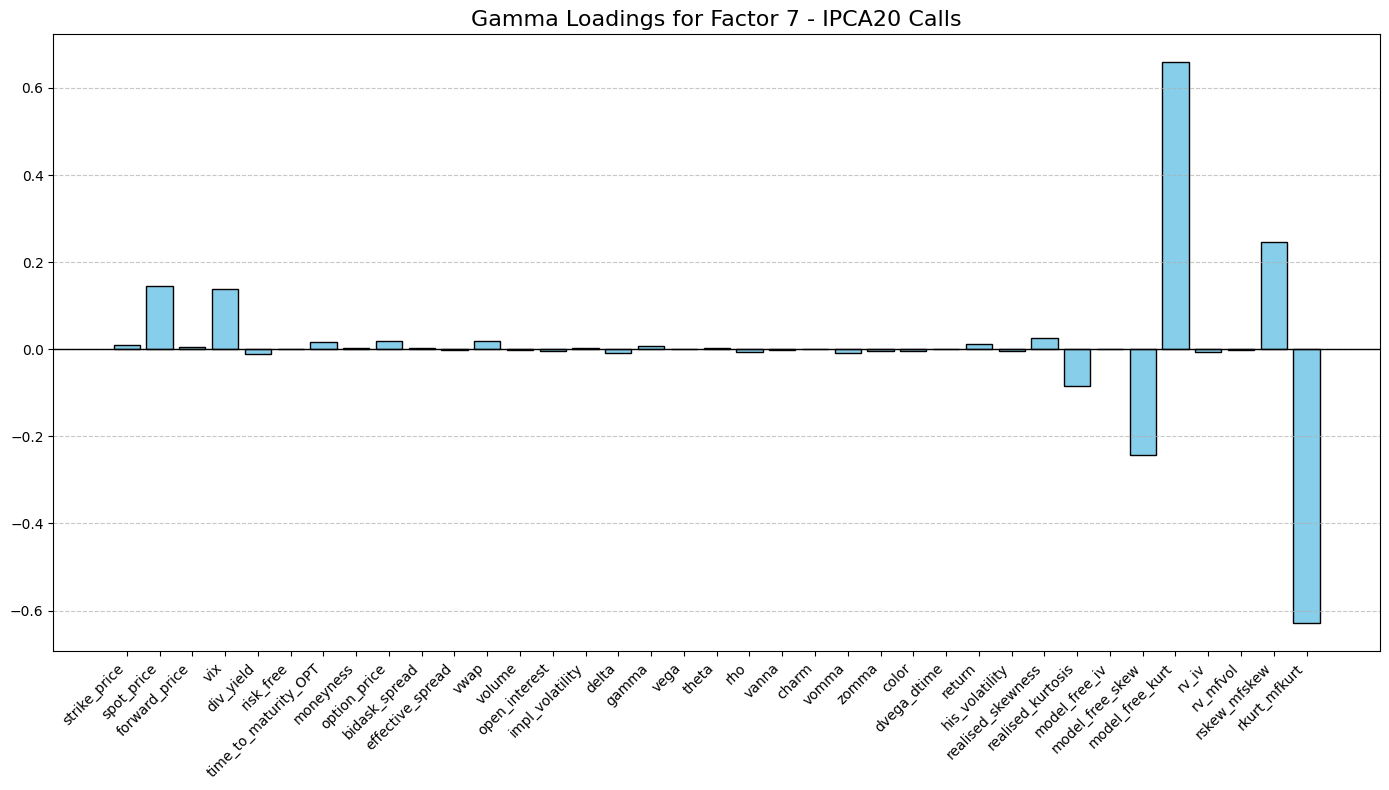

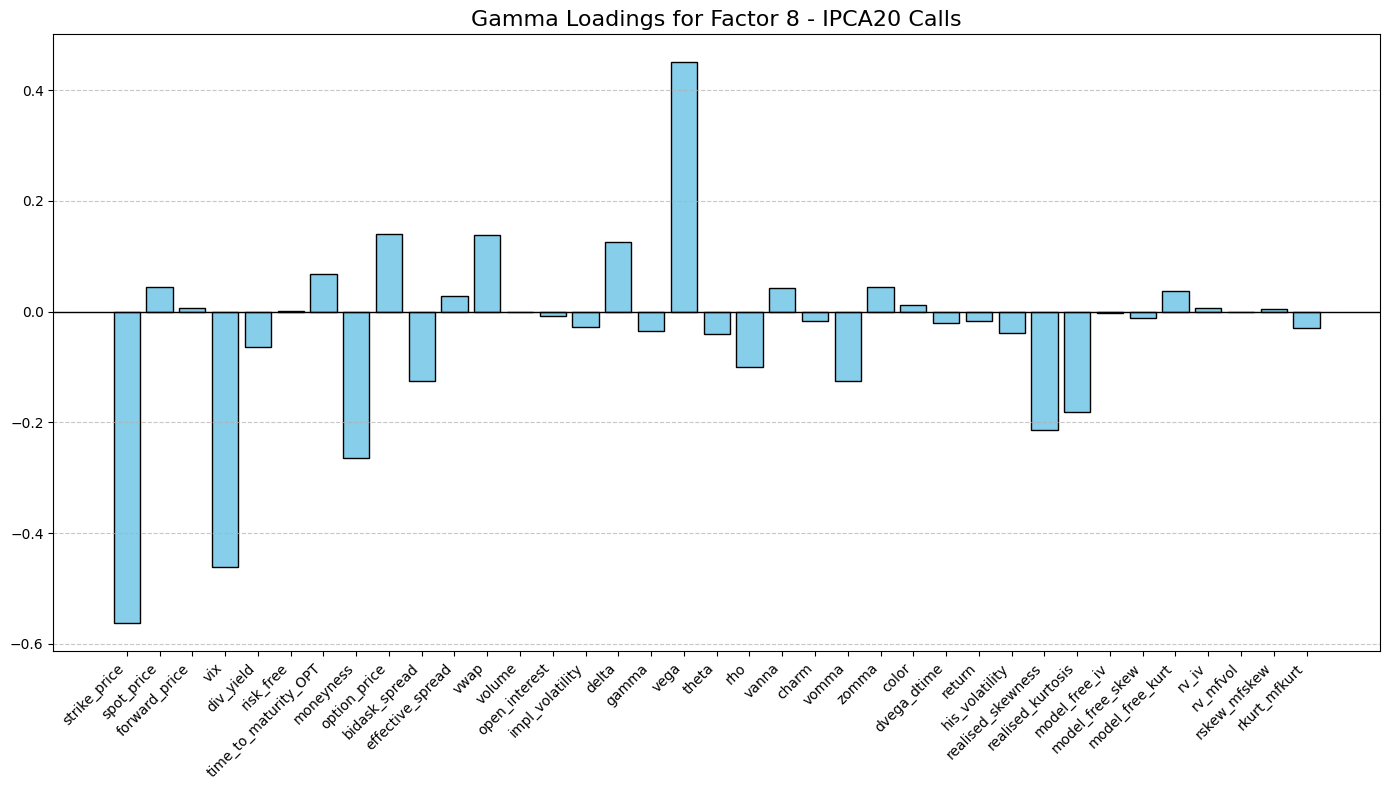

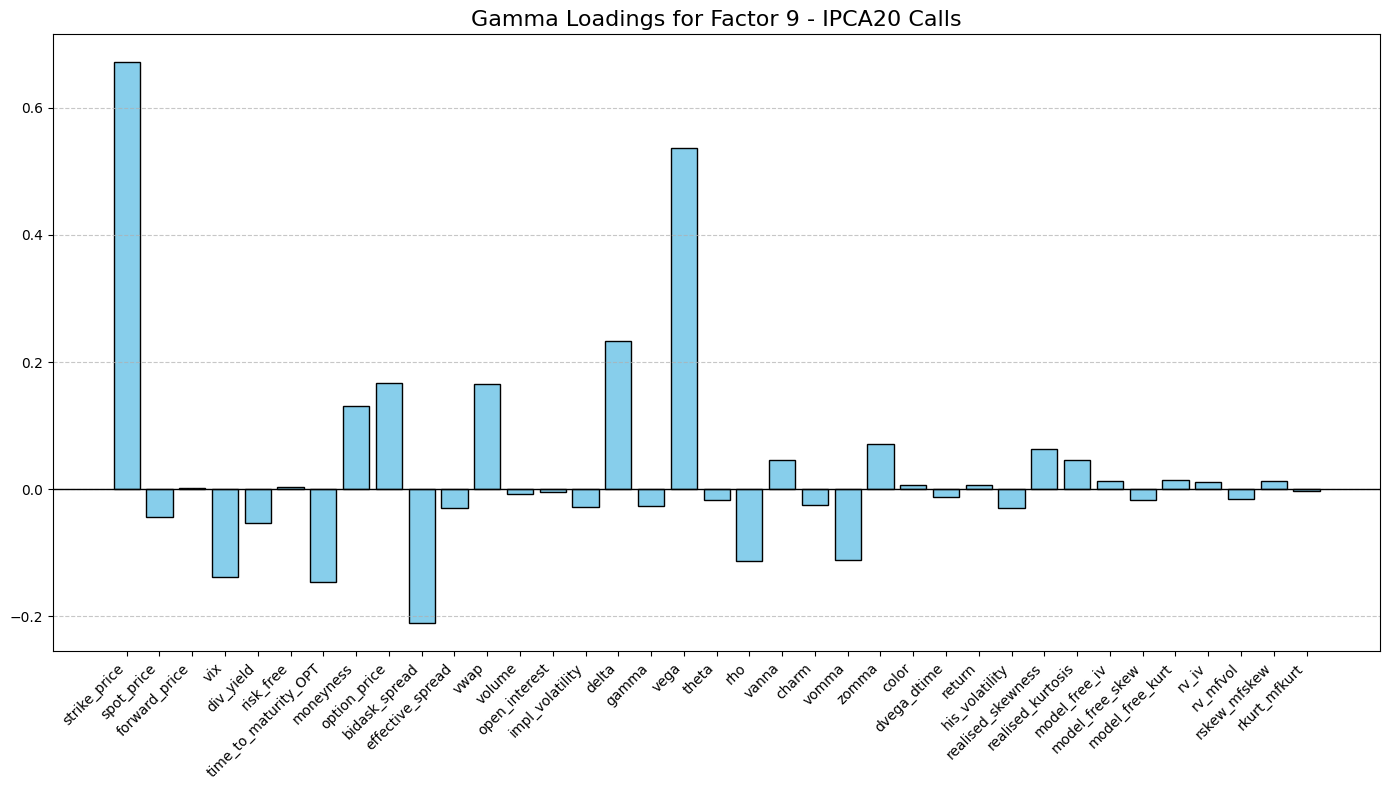

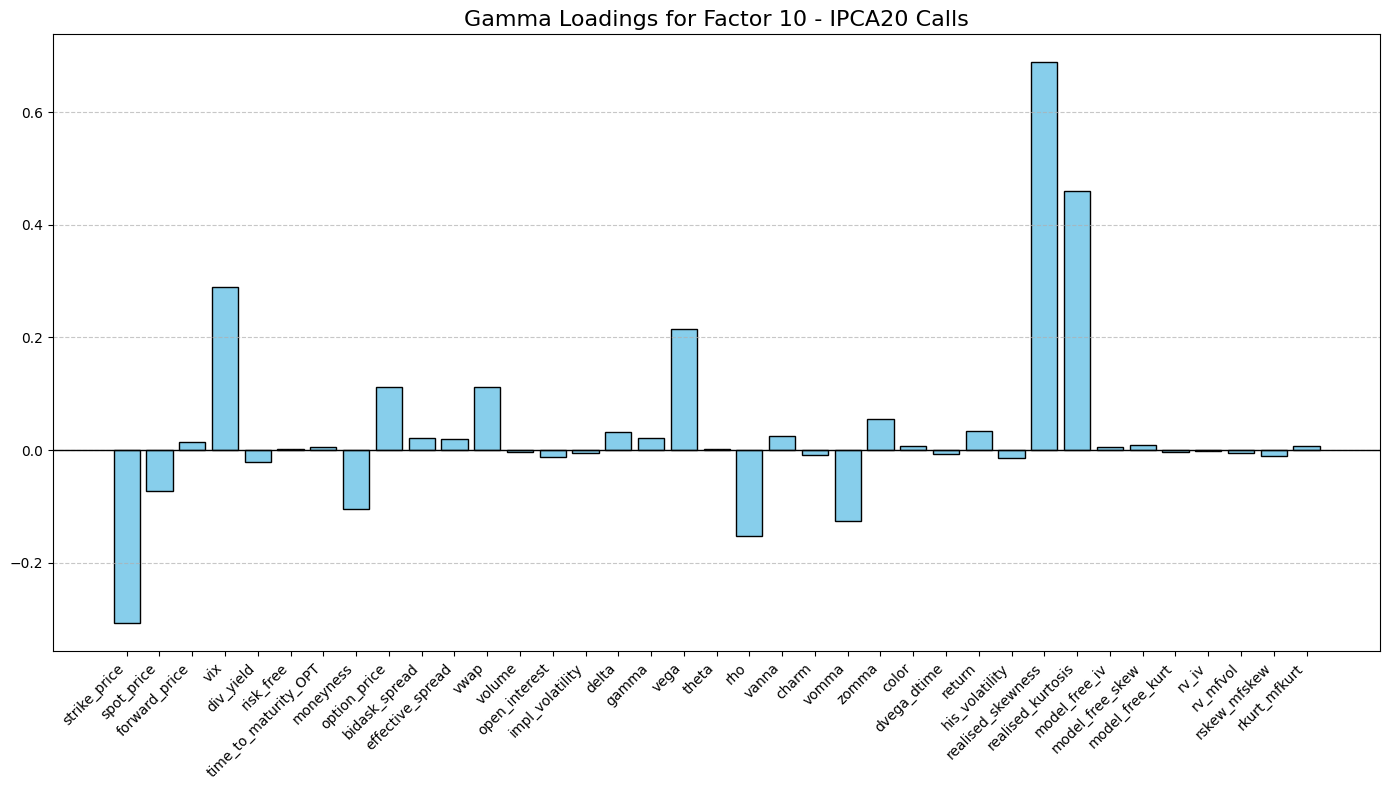

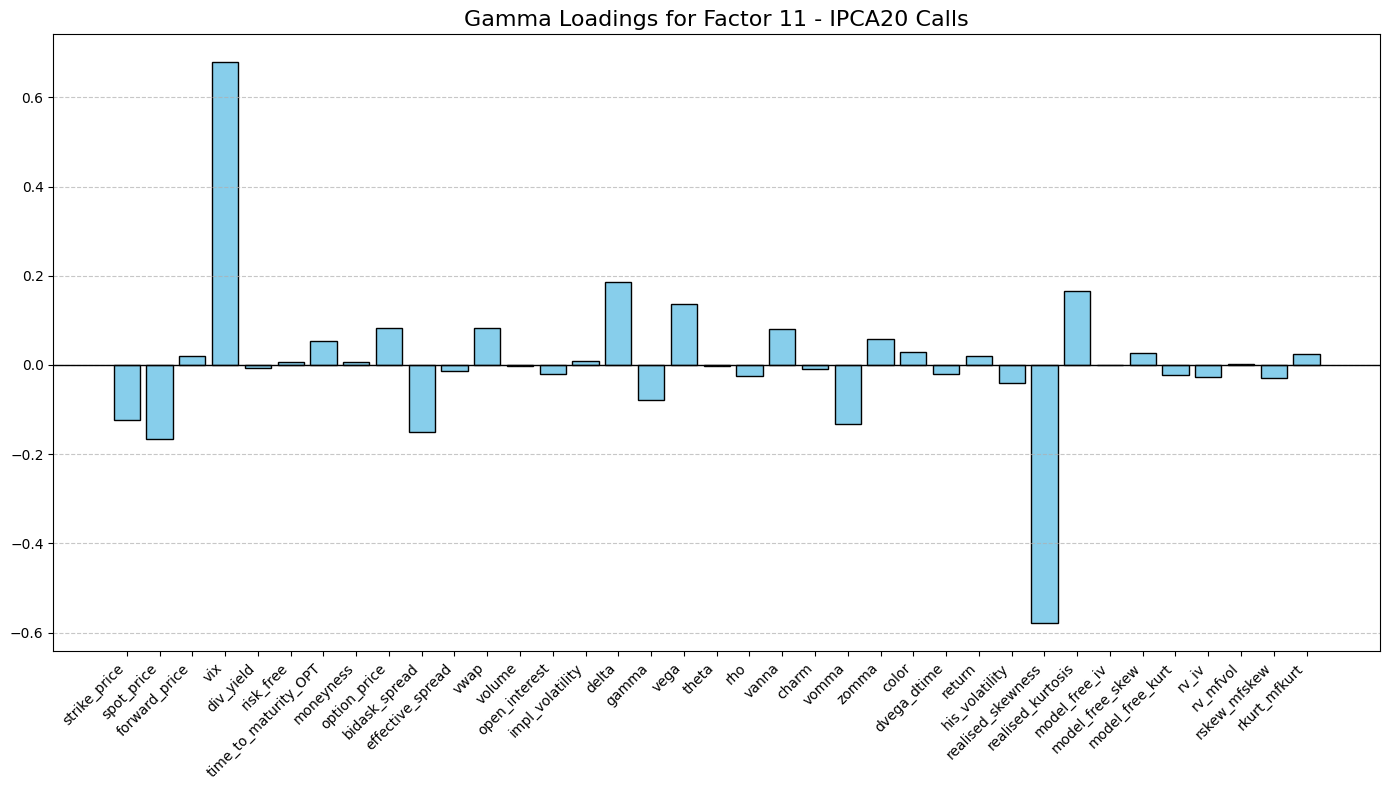

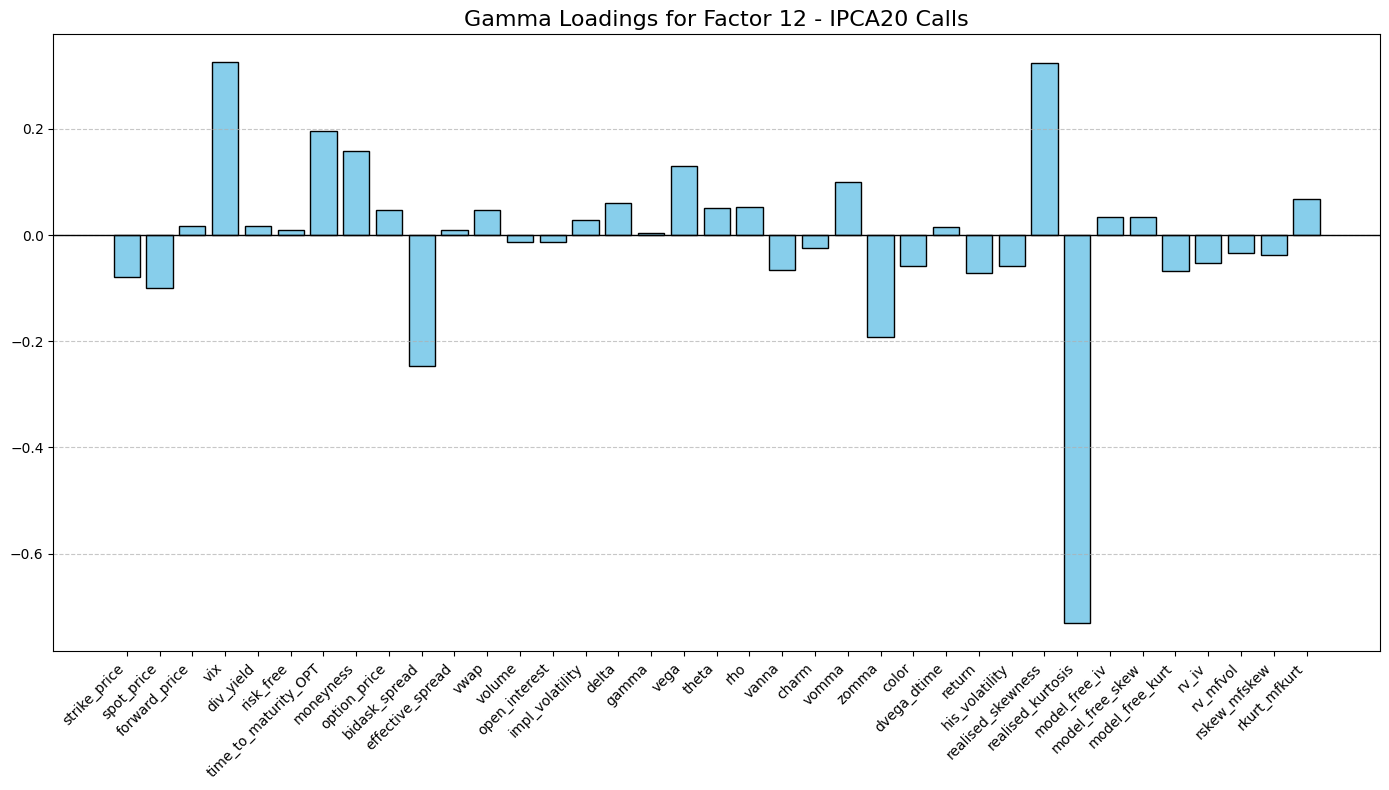

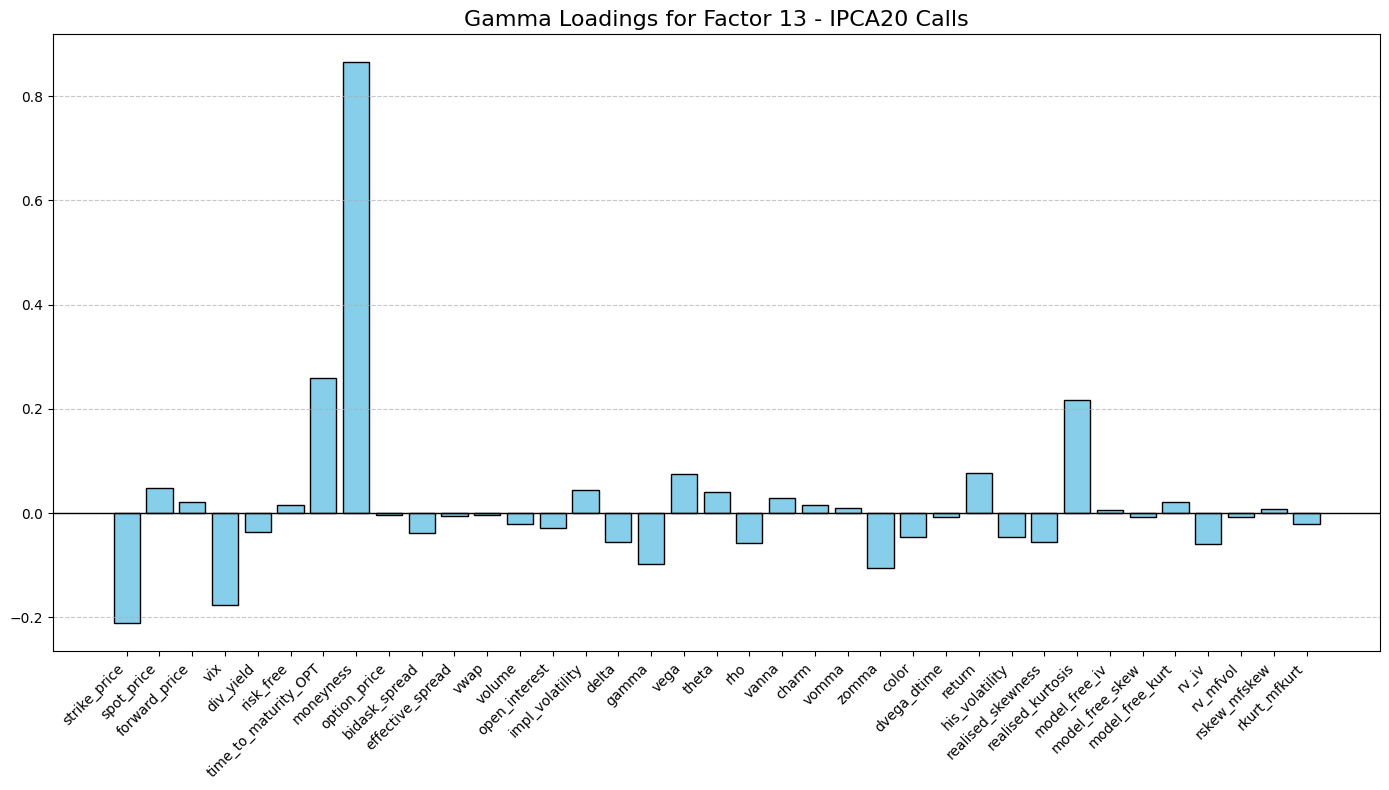

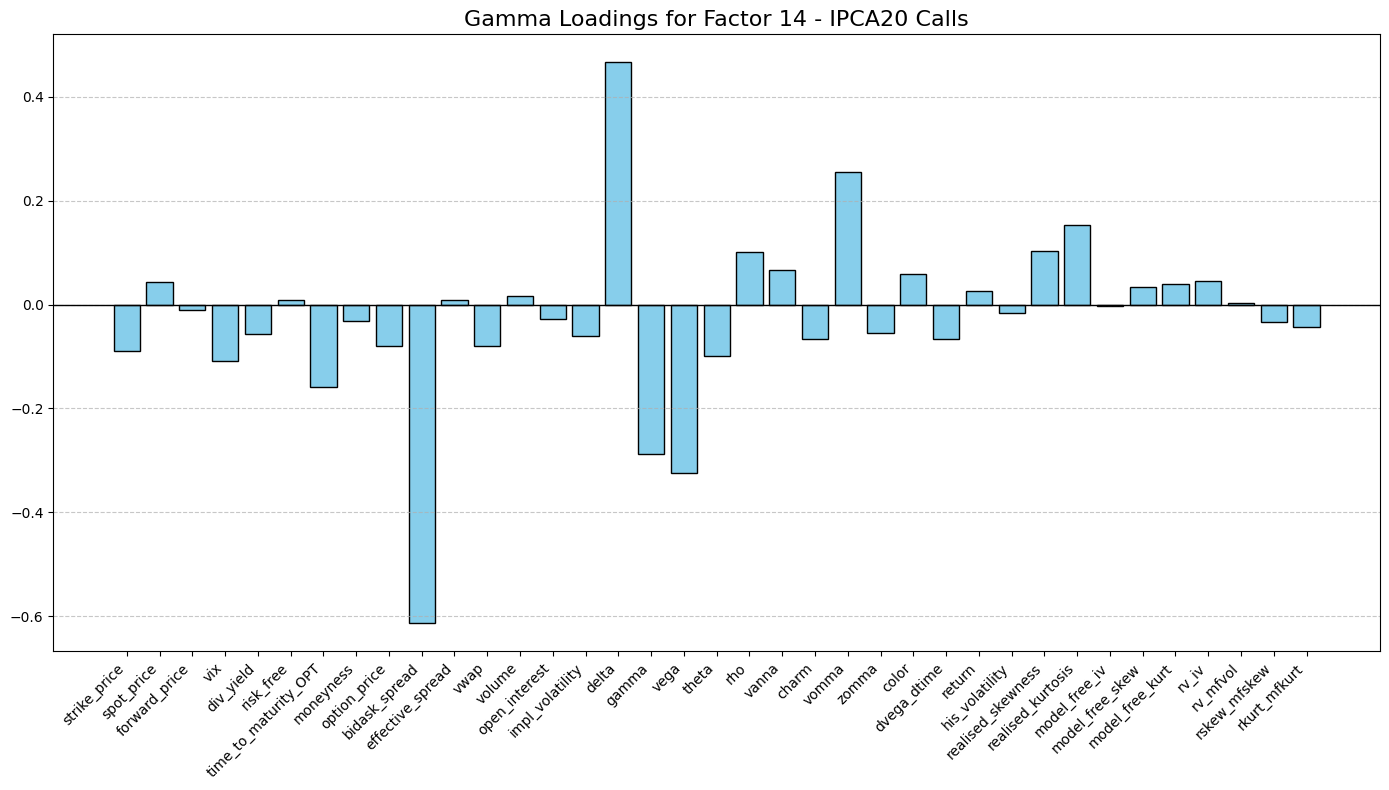

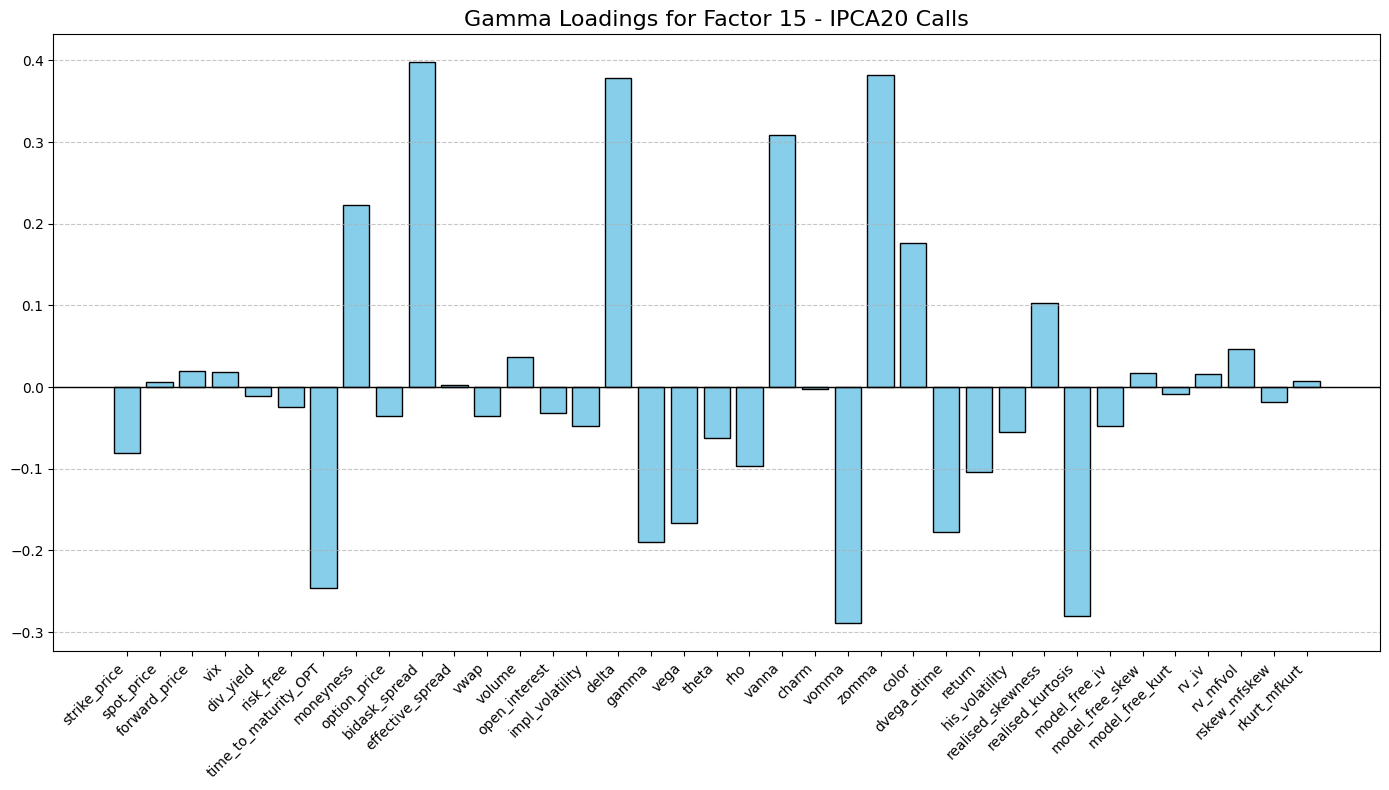

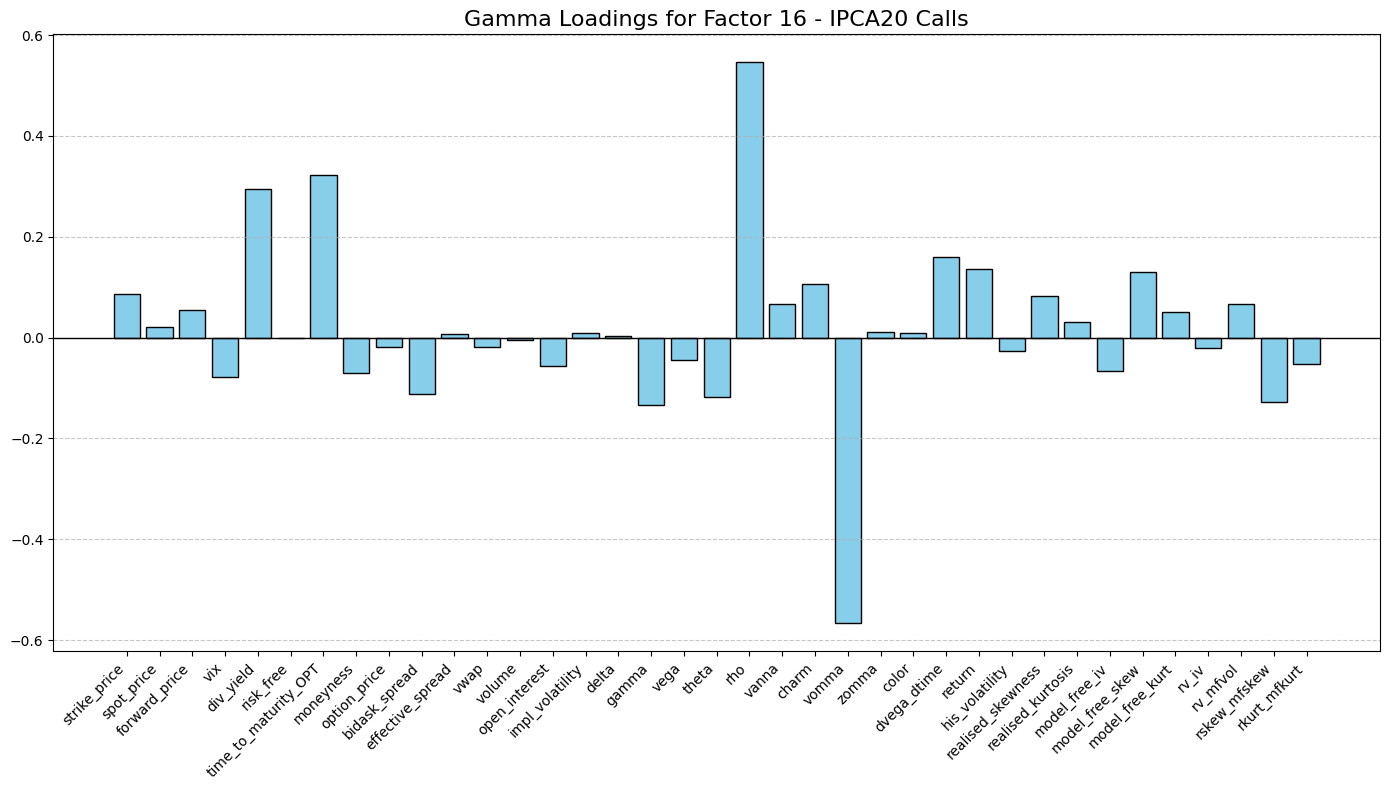

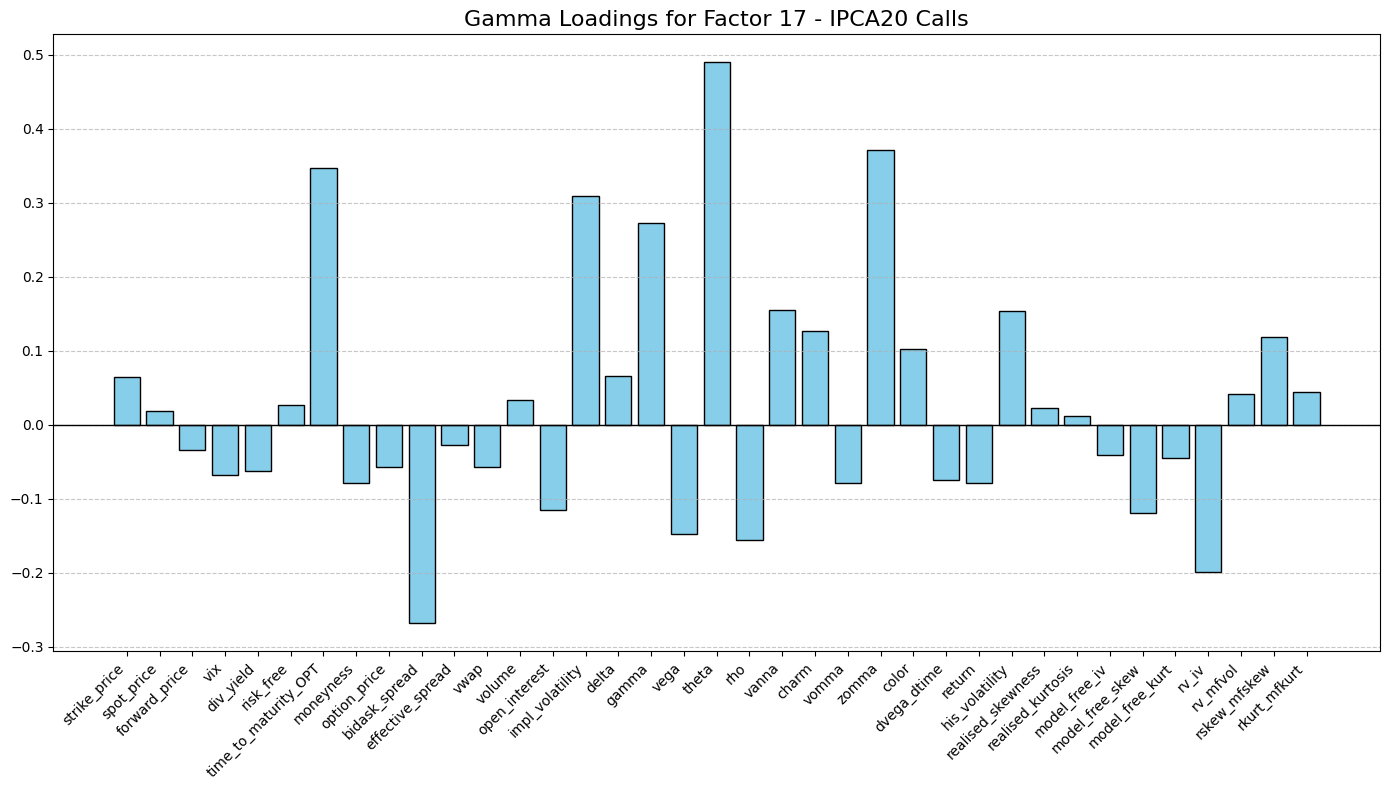

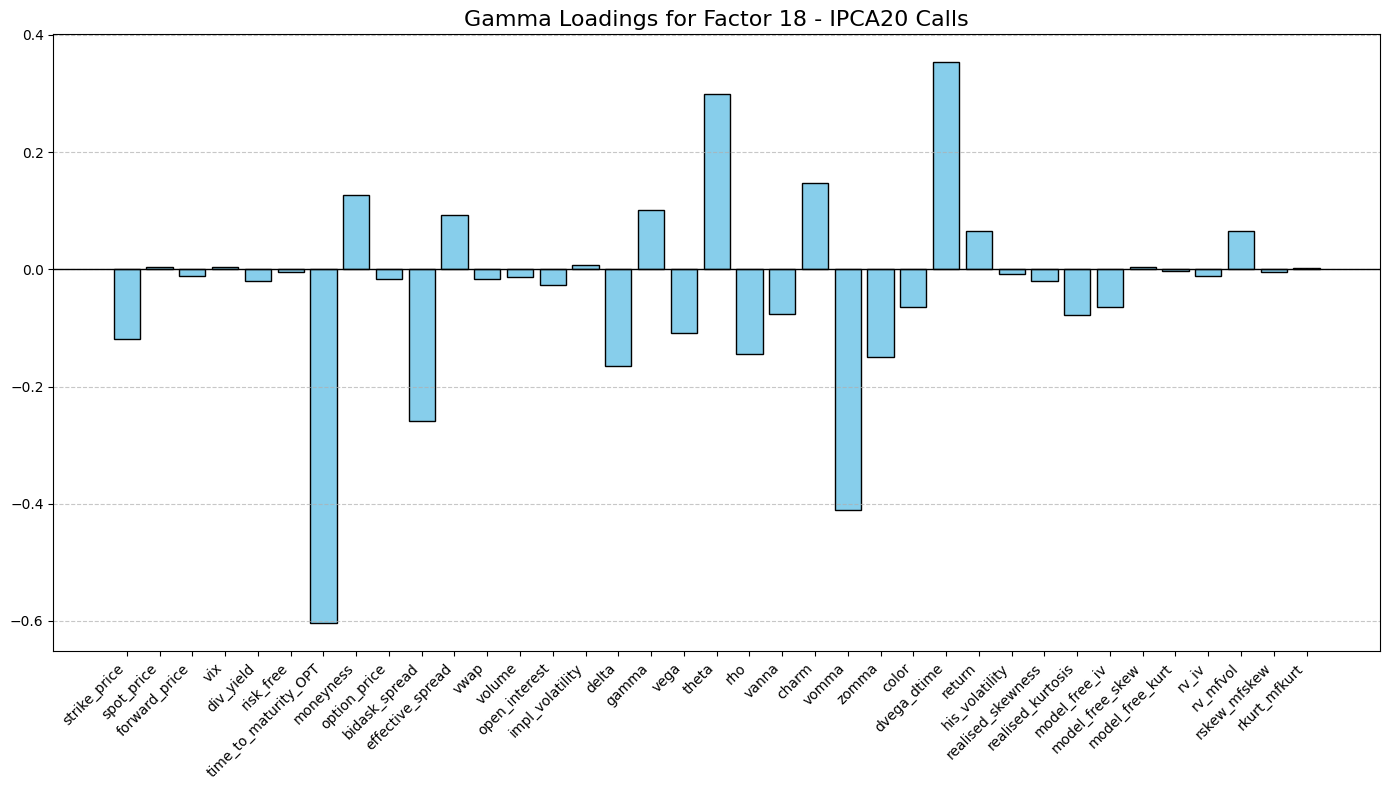

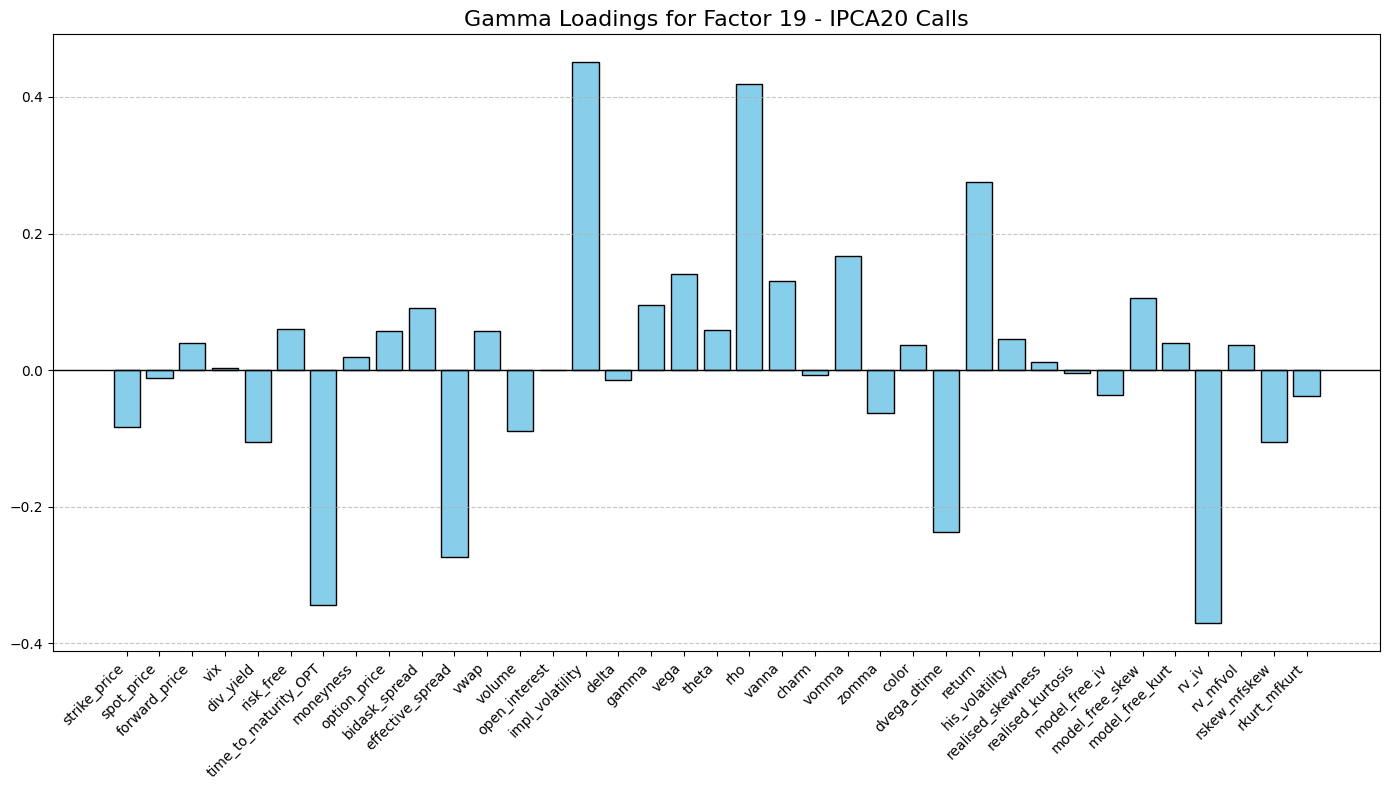

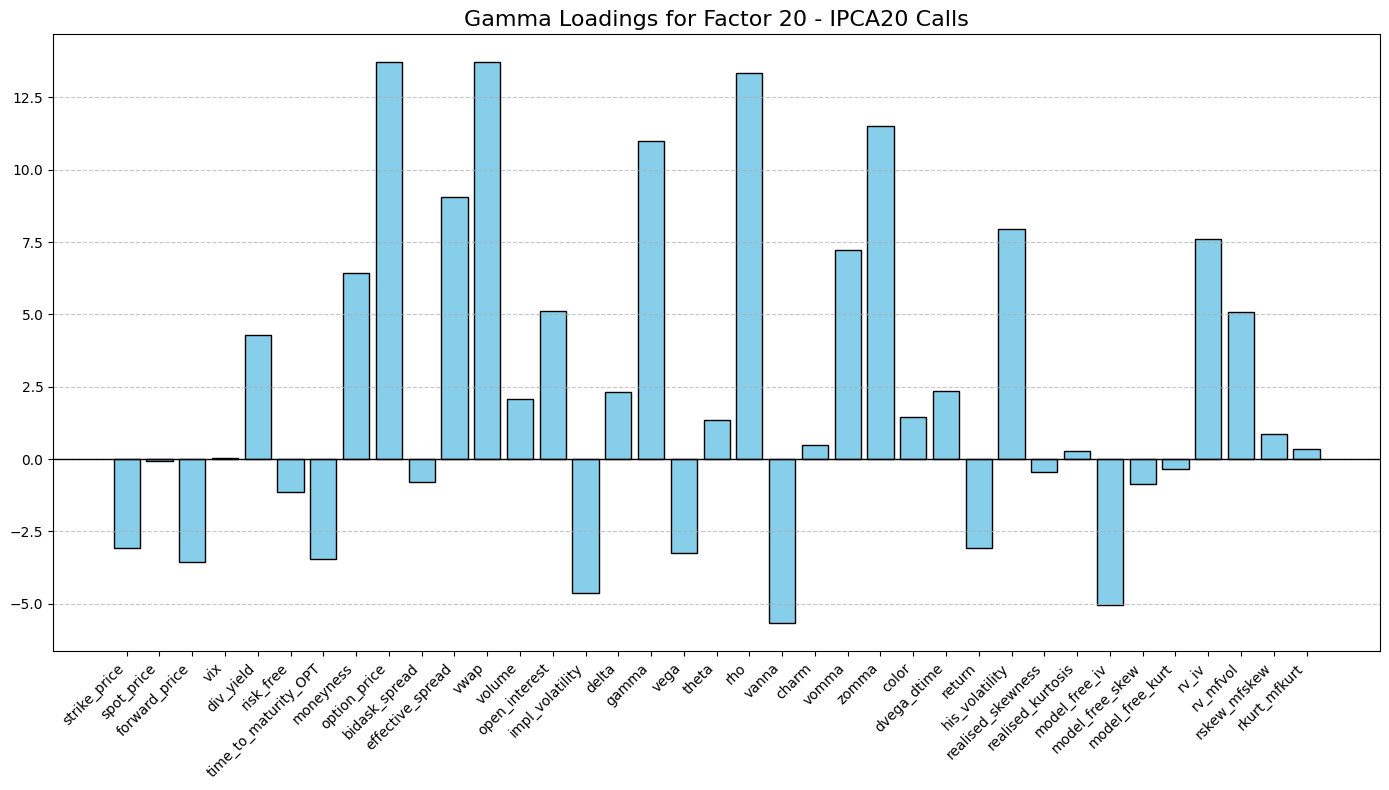

In [30]:
# Gamma loadings for each factor - IPCA20 Calls
for factor in Gamma.columns:
    plt.figure(figsize=(14, 8))
    plt.bar(Gamma.index, Gamma[factor], color='skyblue', edgecolor='black')
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'Gamma Loadings for Factor {factor} - IPCA20 Calls', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Covid Test Set
- Covid testing set from 01/01/2020 to 28/02/2023
- Features are engineered following the same process executed in the notebook "SPX_Preprocessing_DASK"

In [31]:
covid_calls = pd.read_csv('IPCA_Calls_Stress_Test.csv')
covid_calls.drop(['put_payoff'], axis=1, inplace=True)
covid_calls.dropna(inplace=True)
covid_calls.rename(columns={'Unnamed: 0': 'temp_ID'}, inplace=True)
covid_calls.drop(['option_type', 'best_ask', 'best_bid', 'best_bid_size', 'best_ask_size', 'expiration'], axis=1, inplace=True)
covid_calls.columns

Index(['temp_ID', 'date', 'strike_price', 'spot_price', 'forward_price', 'vix',
       'div_yield', 'risk_free', 'time_to_maturity_OPT', 'moneyness',
       'option_price', 'bidask_spread', 'effective_spread', 'vwap', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'rho', 'vanna', 'charm', 'vomma', 'zomma', 'color', 'dvega_dtime',
       'return', 'his_volatility', 'realised_skewness', 'realised_kurtosis',
       'model_free_iv', 'model_free_skew', 'model_free_kurt', 'rv_iv',
       'rv_mfvol', 'rskew_mfskew', 'rkurt_mfkurt', 'call_payoff'],
      dtype='object')

In [32]:
# Monthly panels
covid_calls['date'] = pd.to_datetime(covid_calls['date'])
covid_calls['month'] = covid_calls['date'].dt.to_period('M').dt.to_timestamp().astype('int64') // 10**9

# Unique identifier based on strike and maturity to respect parity conditions
covid_calls['unique_id'] = (covid_calls['strike_price'].astype(str) + '_' + 
                      covid_calls['time_to_maturity_OPT'].astype(str))

# Converting to a numeric ID
unique_ids = np.unique(covid_calls['unique_id'])
ID_map = dict(zip(unique_ids, np.arange(1, len(unique_ids) + 1)))
covid_calls['unique_id'] = covid_calls['unique_id'].apply(lambda x: ID_map[x])
covid_calls.set_index(['unique_id', 'month'], inplace=True)

# Covid testing set
X_test_covid = covid_calls.drop(['call_payoff', 'date', 'temp_ID'], axis=1).select_dtypes(include=[np.number])
y_test_covid = covid_calls['call_payoff']

# Normalisation
X_test_scaled = (X_test_covid - means) / stds
X_test_covid = pd.DataFrame(X_test_scaled, index=X_test_covid.index, columns=X_test_covid.columns)

In [33]:
covid_test_indices = np.array([X_test_covid.index.get_level_values(0), X_test_covid.index.get_level_values(1)]).T

# Out of sample predictions on Covid set
y_test_pred_covid = ipca.predictOOS(X=X_test_covid, y=y_test_covid, indices=covid_test_indices, mean_factor=True)
r2_pred = r2_score(y_test_covid, y_test_pred_covid)
print(f"R² Pred (test): {r2_pred}")

R² Pred (test): 0.9723827051133724


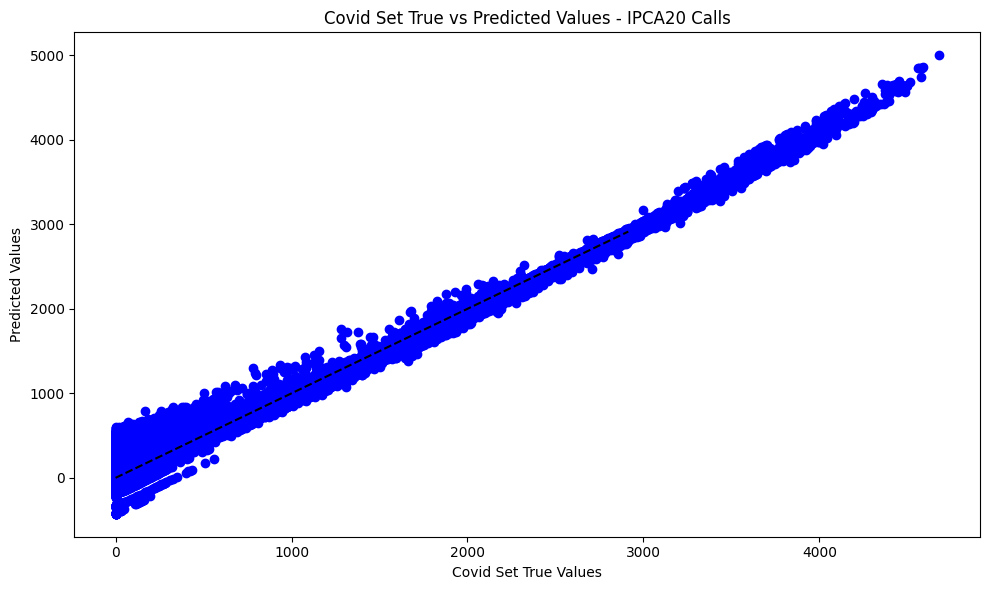

In [34]:
# y_test_covid vs y_test_pred_covid
plt.figure(figsize=(10, 6))
plt.scatter(y_test_covid, y_test_pred_covid, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.xlabel('Covid Set True Values')
plt.ylabel('Predicted Values')
plt.title('Covid Set True vs Predicted Values - IPCA20 Calls')  
plt.tight_layout()
plt.show()

# Saving intermediate datasets for prediction modelling

In [19]:
# Saving test data IPCA 20 Factors Calls
test_data[['date', 'call_payoff', 'spot_price', 'strike_price', 'time_to_maturity_OPT', 'risk_free', 'impl_volatility']].to_csv('Test_Calls20.csv')

In [20]:
# Merging real test Covid and prediction values
y_test = y_test.to_numpy()
df = pd.DataFrame({'True': y_test, 'Predicted': y_test_pred})
df.to_csv('IPCA_Calls_Predictions_Test20.csv')

In [21]:
# Saving Covid test data IPCA 20 Factors Calls
covid_calls[['date', 'call_payoff', 'spot_price', 'strike_price', 'time_to_maturity_OPT', 'risk_free', 'impl_volatility']].to_csv('Covid_Calls20.csv')

In [22]:
# Merging real Covid test and prediction values
y_test_covid = y_test_covid.to_numpy()
df = pd.DataFrame({'True': y_test_covid, 'Predicted': y_test_pred_covid})
df.to_csv('IPCA_Calls_Predictions_Covid20.csv')